In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import csv
import os
import shutil

file_path_id = "/content/drive/MyDrive/version 3 to_release/id_filename.txt"

with open(file_path_id, 'r') as file:
    # 使用csv.reader解析逗號分隔的數據
    reader = csv.reader(file, delimiter=',')

    # 將每行轉換為列表
    id_filename = [row for row in reader]

file_path_train = '/content/drive/MyDrive/version 3 to_release/training_class.txt'

with open(file_path_train, 'r') as file:
    # 使用csv.reader解析逗號分隔的數據
    reader = csv.reader(file, delimiter=',')

    # 將每行轉換為列表
    training_class = [row for row in reader]

In [54]:
# 將資料以字典形式存儲，便於後續處理
id_filename_dict = {int(idx): filename for idx, filename in id_filename}
training_class_dict = {filename: int(label) for filename, label in training_class}
test_dict = {}
for id, filename in id_filename_dict.items():
    if filename not in training_class_dict:
        test_dict[filename] = id
test_image_list=list(test_dict.keys())

### Q1

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [56]:
train_dir = "/content/drive/MyDrive/version 3 to_release/train"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)


Found 1206 files belonging to 4 classes.


In [57]:
validation_dir = "/content/drive/MyDrive/version 3 to_release/valid"
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)


Found 135 files belonging to 4 classes.


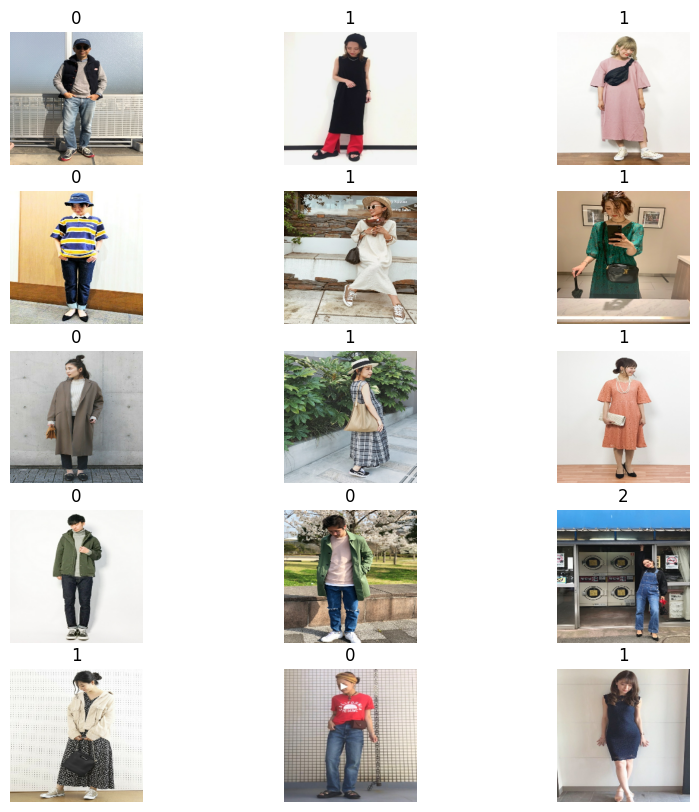

In [58]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [59]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

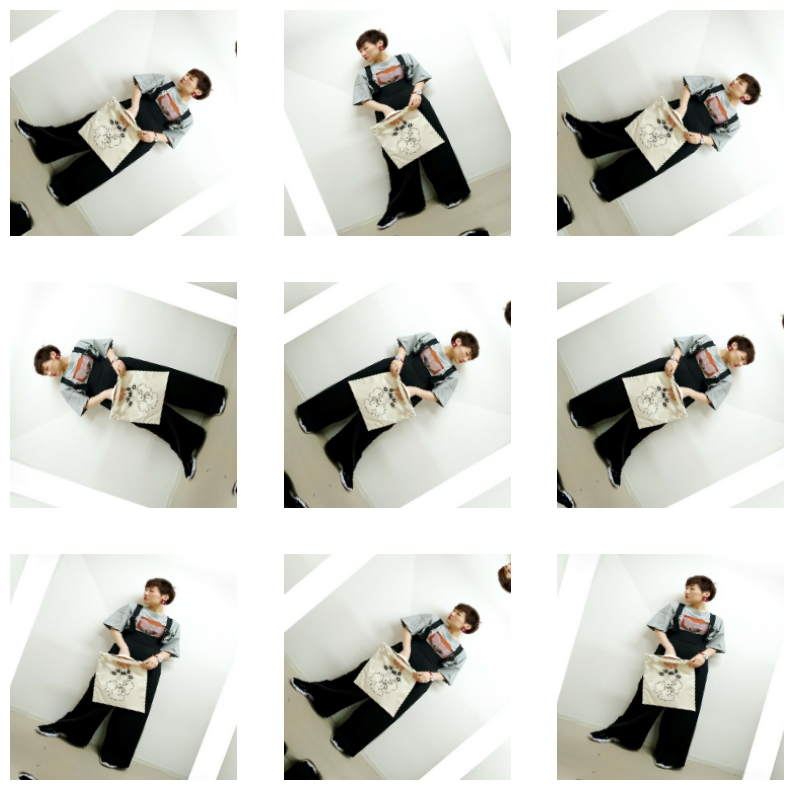

In [60]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [61]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [62]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [63]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [64]:
base_model.trainable = False

In [65]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [66]:
num_classes = 4  # 假設有4個類別，根據實際情況調整

# 添加 Dense 層，使用 softmax 激活函數
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

print(prediction_batch.shape)

(32, 4)


In [67]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [68]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,SparseCategoricalAccuracy
base_learning_rate = 0.0001
optimizer = Adam(learning_rate=base_learning_rate)

# 選擇損失函數，使用 CategoricalCrossentropy 並設置 from_logits=True
loss_function = SparseCategoricalCrossentropy(from_logits=False)

# 選擇評估指標，使用 CategoricalAccuracy
metrics = [SparseCategoricalAccuracy(name='accuracy')]

# 編譯模型
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

In [69]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

5/5 [==============================] - 2s 70ms/step - loss: 2.0342 - accuracy: 0.3111


In [70]:
initial_epochs = 20
history = model.fit(train_dataset,
            epochs=initial_epochs,
            validation_data=validation_dataset)

Epoch 1/20
38/38 [==============================] - 11s 101ms/step - loss: 1.6423 - accuracy: 0.3226 - val_loss: 1.3131 - val_accuracy: 0.3185
Epoch 2/20
38/38 [==============================] - 5s 107ms/step - loss: 1.4232 - accuracy: 0.3972 - val_loss: 1.1518 - val_accuracy: 0.4667
Epoch 3/20
38/38 [==============================] - 7s 140ms/step - loss: 1.2856 - accuracy: 0.4544 - val_loss: 1.0506 - val_accuracy: 0.5556
Epoch 4/20
38/38 [==============================] - 5s 107ms/step - loss: 1.2389 - accuracy: 0.4892 - val_loss: 0.9538 - val_accuracy: 0.6296
Epoch 5/20
38/38 [==============================] - 6s 129ms/step - loss: 1.1487 - accuracy: 0.5141 - val_loss: 0.8913 - val_accuracy: 0.6667
Epoch 6/20
38/38 [==============================] - 6s 118ms/step - loss: 1.0788 - accuracy: 0.5680 - val_loss: 0.8504 - val_accuracy: 0.6741
Epoch 7/20
38/38 [==============================] - 8s 186ms/step - loss: 1.0392 - accuracy: 0.5730 - val_loss: 0.8167 - val_accuracy: 0.6889
Epoch

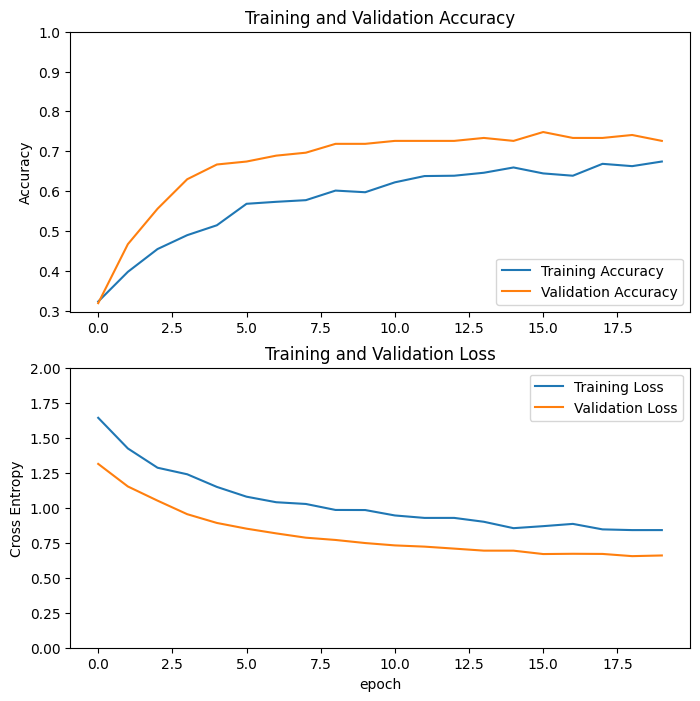

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [72]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  311


In [73]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [74]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40
38/38 [==============================] - 24s 215ms/step - loss: 0.7579 - accuracy: 0.7007 - val_loss: 0.5413 - val_accuracy: 0.7630
Epoch 21/40
38/38 [==============================] - 7s 179ms/step - loss: 0.6003 - accuracy: 0.7645 - val_loss: 0.4681 - val_accuracy: 0.8370
Epoch 22/40
38/38 [==============================] - 8s 168ms/step - loss: 0.5366 - accuracy: 0.8076 - val_loss: 0.4237 - val_accuracy: 0.8444
Epoch 23/40
38/38 [==============================] - 8s 182ms/step - loss: 0.4607 - accuracy: 0.8325 - val_loss: 0.4214 - val_accuracy: 0.8593
Epoch 24/40
38/38 [==============================] - 7s 162ms/step - loss: 0.4090 - accuracy: 0.8449 - val_loss: 0.4265 - val_accuracy: 0.8222
Epoch 25/40
38/38 [==============================] - 8s 195ms/step - loss: 0.3857 - accuracy: 0.8599 - val_loss: 0.3930 - val_accuracy: 0.8444
Epoch 26/40
38/38 [==============================] - 7s 163ms/step - loss: 0.3218 - accuracy: 0.8922 - val_loss: 0.3918 - val_accuracy: 0.866

In [75]:
from PIL import Image
test_folder = "/content/drive/MyDrive/version 3 to_release/test"
x_test = []
f_name=[]
# 遍歷 test_dict 中的每一個 key (檔案名稱)
for filename in test_dict.keys():
    f_name.append(filename)
    # 組合圖片的完整路徑
    image_path = os.path.join(test_folder, filename)

    # 使用 Pillow 打開圖片
    image = Image.open(image_path)
    image = image.resize((224, 224))
    # 將圖片轉換為 NumPy 數組

    image_array = np.array(image)

    # 將數據添加到列表中
    x_test.append(image_array)

x_test = np.array(x_test)

In [76]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

7/7 [==============================] - 2s 77ms/step


In [77]:
p=predicted_classes+1

In [78]:
predicted_classes_list = p.tolist()

In [79]:
p

array([1, 3, 1, 4, 2, 1, 1, 2, 1, 3, 3, 2, 1, 4, 3, 2, 4, 1, 2, 3, 1, 2,
       1, 2, 3, 1, 1, 2, 4, 4, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 1, 2, 2, 2, 4, 1, 1, 3, 3, 1, 2, 2, 1, 2, 1, 4, 1, 2, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 4, 1, 1, 2, 1, 3, 1, 2, 2, 1, 1,
       2, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 4, 3, 1, 1, 1, 4, 1, 2, 1,
       2, 4, 1, 2, 2, 3, 2, 2, 3, 2, 2, 1, 2, 4, 1, 2, 3, 2, 4, 1, 2, 2,
       4, 2, 1, 1, 1, 3, 3, 1, 2, 2, 2, 3, 1, 1, 1, 2, 4, 3, 4, 1, 4, 4,
       1, 1, 4, 3, 2, 3, 1, 2, 2, 4, 1, 1, 2, 2, 1, 1, 1, 4, 2, 1, 2, 1,
       2, 2, 3, 4, 1, 1, 2, 3, 1, 1, 1, 1, 3, 1, 2, 2, 1, 1, 1, 2, 3, 1,
       3, 2, 2, 1, 3, 4, 3, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2])

In [80]:
predicted_classes_list = predicted_classes.tolist()
import pandas as pd
id_list = [test_dict[filename] for filename in test_dict.keys()]
f1 = pd.DataFrame({'id': id_list, 'label': p})
f1.to_csv("/content/drive/MyDrive/version 3 to_release/r113230283.csv")

### Q2

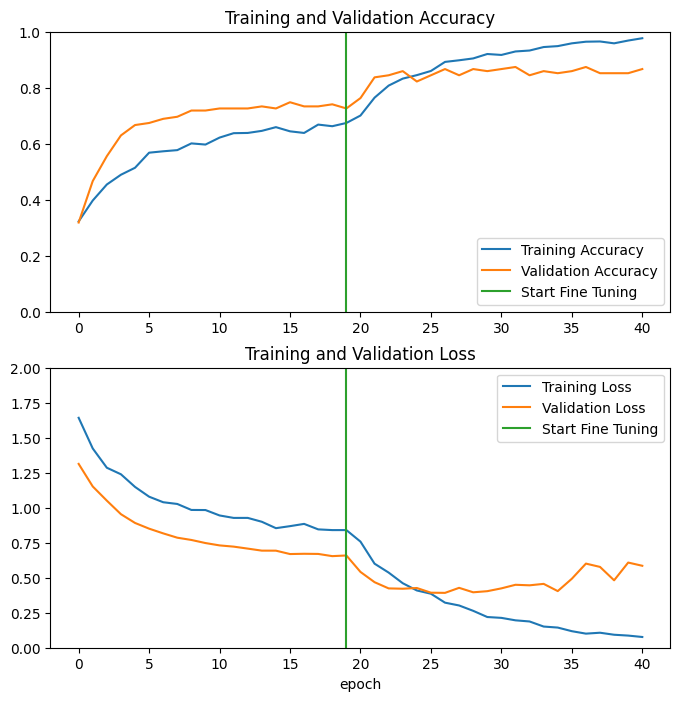

In [81]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()